# Contact Graph Generator

In [1]:
import logging
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.contact.contact_regions_set import ContactRegionParams

import numpy as np
from copy import deepcopy
from IPython.display import HTML
from matplotlib import pyplot as plt


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
logging.getLogger("large_gcs").setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

/afs/csail.mit.edu/u/s/shaoyuan/Documents/Software/pypolycontain/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/afs/csail.mit.edu/u/s/shaoyuan/Documents/Software/pypolycontain/pypolycontain/containment.py:16: UserWarning: You don't have CDD package installed. Unable to run cone ray generation.
  warnings.warn("You don't have CDD package installed. Unable to run cone ray generation.")


# For collecting results to configure pytest tests

In [ ]:
from large_gcs.cost_estimators.factored_collision_free_ce import FactoredCollisionFreeCE
from large_gcs.graph.graph import ShortestPathSolution


graph_file = ContactGraphGeneratorParams.inc_graph_file_path_from_name("cg_trichal2")
# cg = ContactGraph.load_from_file(graph_file)
cg = IncrementalContactGraph.load_from_file(
    graph_file,
    should_incl_simul_mode_switches=False,
    should_add_const_edge_cost=False,
    should_add_gcs=False,
)
cost_estimator = FactoredCollisionFreeCE(
    cg,
    use_combined_gcs=False,
    add_transition_cost=True,
    obj_multiplier=100.0,
)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol: ShortestPathSolution = gcs_astar.run()

In [ ]:
str(sol)

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

# Simple Demo

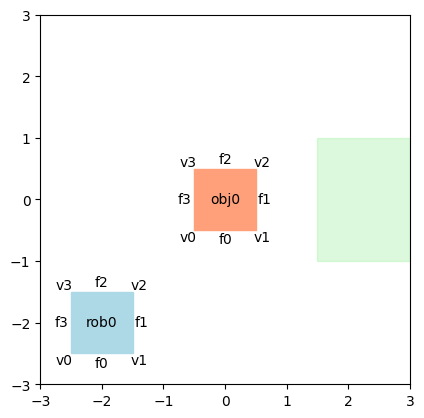

In [2]:
ws = 3
target_regions = [
    ContactRegionParams(
        region_vertices=[[1.5, -1], [1.5, 1], [3, 1], [3, -1]], obj_indices=[0]
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_1",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]])],
    rob_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
    should_use_l1_norm_vertex_cost=True,
)
generator = ContactGraphGenerator(params)
generator.plot()

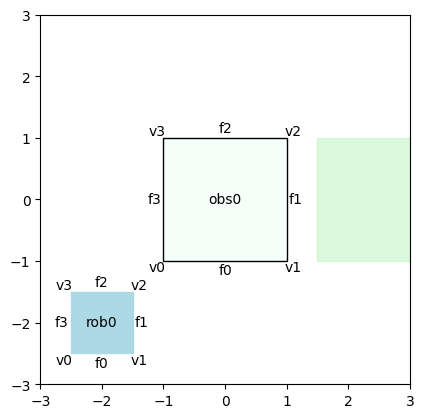

In [3]:
ws = 3
target_regions = [
    ContactRegionParams(
        region_vertices=[[1.5, -1], [1.5, 1], [3, 1], [3, -1]], rob_indices=[0]
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_1_1",
    obs_vertices=[np.array([[0, 0], [2, 0], [2, 2], [0, 2]]) + np.array([-1, -1])],
    obj_vertices=[],
    rob_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]])],
    source_obj_pos=[],
    source_rob_pos=[[-2, -2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
    should_use_l1_norm_vertex_cost=True,
)
generator = ContactGraphGenerator(params)
generator.plot()

In [5]:
cg=generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 118.50it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 4 sets...
100%|██████████| 4/4 [00:00<00:00, 1567.82it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 4/4 [00:00<00:00, 184.82it/s]
INFO:large_gcs.graph.contact_graph:4 sets remain after removing 0 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 6/6 [00:00<00:00, 15524.88it/s]
INFO:large_gcs.graph.graph:Adding 6 vertices to graph...
100%|██████████| 6/6 [00:00<00:00, 20712.61it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 15/15 [00:00<00:00, 1169.13it/s]
INFO:large_gcs.graph.contact_graph:11 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 11/11 [00:00<00:00, 18157.16it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|████

In [6]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 33156.55it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 19737.90it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 145.43it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (6)
100%|██████████| 6/6 [00:00<00:00, 632.37it/s]


INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 51150.05it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 25191.02it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 164.52it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (6)
100%|██████████| 6/6 [00:00<00:00, 1953.56it/s]


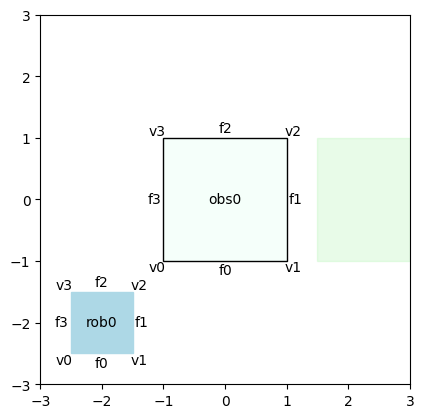

In [7]:
cg=IncrementalContactGraph.load_from_file(params.inc_graph_file_path,
                                          should_use_l1_norm_vertex_cost=True,)
cg.plot()

## Simple Demo 2

In [ ]:
ws = 3
params = ContactGraphGeneratorParams(
    name="cg_simple_2",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_obj_pos=[[2, 0]],
    target_rob_pos=[[2.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Simple Demo 3 (Target Region)

In [ ]:
ws = 3
target_regions = [
    ContactRegionParams(
        region_vertices=[[1.5, -1], [1.5, 1], [3, 1], [3, -1]], obj_indices=[0]
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_3",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
ws = 3.5
target_regions = [
    ContactRegionParams(
        region_vertices=[[1.5, -1], [1.5, 1], [3, 1], [3, -1]], obj_indices=[0]
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_4",
    obs_vertices=[np.array([[0, 0], [2, 0], [2, 2], [0, 2]]) + np.array([-1, -1])],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]])],
    rob_vertices=[np.array([[0, 0], [0.5, 0], [0.5, 0.5], [0, 0.5]])],
    source_obj_pos=[[-2, 0]],
    source_rob_pos=[[0, -2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
    should_add_const_edge_cost=True,
    should_use_l1_norm_vertex_cost=True,
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
ws = 3.5
target_regions = [
    ContactRegionParams(
        region_vertices=[[1, -0.5], [1, 0.5], [3, 0.5], [3, -0.5]], obj_indices=[0]
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_5",
    obs_vertices=[np.array([[0, -1], [2, -1], [2, 2], [0, 2]]) + np.array([-1, -1])],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]])],
    rob_vertices=[np.array([[0, 0], [0.5, 0], [0.5, 0.5], [0, 0.5]])],
    source_obj_pos=[[-2, 0]],
    source_rob_pos=[[2, 2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
    should_add_const_edge_cost=True,
    should_use_l1_norm_vertex_cost=True,
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

In [ ]:
cost_estimator = ShortcutEdgeCE(
    cg_inc,
    shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted,
)
gcs_astar = GcsAstarConvexRestriction(
    cg_inc,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

# Triangle Challenge

## Triangle Challenge 2

In [ ]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal2",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[-3, 0]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

### Testing solution methods

In [ ]:
logging.getLogger("large_gcs.algorithms.gcs_astar_convex_restriction").setLevel(
    logging.DEBUG
)
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

## Triangle Challenge 3

In [ ]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal3",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[-3, 0]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[1.5, 0.5]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

In [ ]:
cg_inc.plot()

## Triangle Challenge 4 (Target Region)

In [ ]:
ws_x = 5
ws_y = 4
target_region_params = [
    ContactRegionParams(
        region_vertices=[[-3, -0.75], [-3, 1], [-1, -0.75], [-1, 1]], obj_indices=[0]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_trichal4",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Trichal 5-15

In [ ]:
seed = 0
ws_x = 5
ws_y = 4
bl = np.array([-ws_x, -ws_y])
tr_width = 1.5
target_region_vertices = np.array(
    [
        bl,
        bl + np.array([tr_width, 0]),
        bl + np.array([tr_width, tr_width]),
        bl + np.array([0, tr_width]),
    ]
)
generators = []
i = 0
while len(generators) < 10:
    i += 1
    np.random.seed(seed + i)
    target_region_offset = np.random.uniform(
        [0, 0], [2 * ws_x - tr_width, 2 * ws_y - tr_width]
    )
    target_region_params = [
        ContactRegionParams(
            region_vertices=target_region_vertices + target_region_offset,
            obj_indices=[0],
        ),
    ]
    buffer = 2
    body_offsets = np.random.uniform(
        [-ws_x + buffer, -ws_y + buffer], [ws_x - buffer, ws_y - buffer], size=(2, 2)
    )

    params = ContactGraphGeneratorParams(
        name="cg_trichal" + str(len(generators) + 5),
        obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
        obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
        rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
        source_obj_pos=[np.zeros(2) + body_offsets[0]],
        source_rob_pos=[np.zeros(2) + body_offsets[1]],
        target_region_params=target_region_params,
        n_pos_per_set=2,
        workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
    )

    generator = ContactGraphGenerator(params)
    is_valid = generator.is_valid()
    # print(is_valid)
    if is_valid:
        generators.append(generator)
        print(len(generators))
    # generator.plot()
    # plt.show()

In [ ]:
for i, generator in enumerate(generators):
    # generator.plot()
    # plt.show()
    generator.generate_incremental_contact_graph()

# Maze a

## Maze a1

In [ ]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a1",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.6]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Maze a2

In [ ]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a2",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Maze a3

In [ ]:
ws_x = 5
ws_y = 5
bl = np.array([-ws_x, -ws_y])
tr_width = 1.1
target_region_vertices = np.array(
    [
        bl,
        bl + np.array([tr_width, 0]),
        bl + np.array([tr_width, tr_width]),
        bl + np.array([0, tr_width]),
    ]
)
target_region_offset = np.array([2.3, 4])
target_region_params = [
    ContactRegionParams(
        region_vertices=target_region_vertices + target_region_offset,
        obj_indices=[0],
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_maze_a3",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

In [ ]:
ws_x = 5
ws_y = 5
bl = np.array([-ws_x, -ws_y])
tr_width = 1.1
target_region_vertices = np.array(
    [
        bl,
        bl + np.array([tr_width, 0]),
        bl + np.array([tr_width, tr_width]),
        bl + np.array([0, tr_width]),
    ]
)
target_region_offset = np.array([2, 0.3])
target_region_params = [
    ContactRegionParams(
        region_vertices=target_region_vertices + target_region_offset,
        obj_indices=[0],
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_maze_c1",
    obs_vertices=[
        [[-2, -2.7], [1.7, 2.6], [-3.3, 0.5]] + np.array([1, 1]),
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]] + np.array([1, 1]),
        [[0, -5], [2, -5], [-3, -2.5]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[2.6, 1.6]],
    source_rob_pos=[[4.25, 0]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
ws_x = 5
ws_y = 5
bl = np.array([-ws_x, -ws_y])
tr_width = 1.1
target_region_vertices = np.array(
    [
        bl,
        bl + np.array([tr_width, 0]),
        bl + np.array([tr_width, tr_width]),
        bl + np.array([0, tr_width]),
    ]
)
target_region_offset = np.array([2, 0.3])
target_region_params = [
    ContactRegionParams(
        region_vertices=target_region_vertices + target_region_offset,
        obj_indices=[0],
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_maze_c2",
    obs_vertices=[
        [[-2, -2.7], [1.5, 2.4], [-3.3, 0.5], [-2, 2.5]] + np.array([1, 1]),
        [
            [0.5, -2],
            [1.7, -3.2],
            [2.7, -1.2],
            [2.4, 0.3],
        ]
        + np.array([1, 1]),
        [[0, -5], [2, -5], [-3, -2.5]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[2.6, 1.6]],
    source_rob_pos=[[4.25, 0]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Maze a10-a39

In [ ]:
ws_x = 5
ws_y = 5
seed = 123
bl = np.array([-ws_x, -ws_y])
tr_width = 1.1
target_region_vertices = np.array(
    [
        bl,
        bl + np.array([tr_width, 0]),
        bl + np.array([tr_width, tr_width]),
        bl + np.array([0, tr_width]),
    ]
)
generators = []
i = 0
while len(generators) < 30:
    i += 1
    np.random.seed(seed + i)
    buffer = 2
    target_region_offset = np.random.uniform(
        [0, 0], [2 * ws_x - buffer, 2 * ws_y - buffer]
    )
    target_region_params = [
        ContactRegionParams(
            region_vertices=target_region_vertices + target_region_offset,
            obj_indices=[0],
        ),
    ]

    body_offsets = np.random.uniform(
        [-ws_x + buffer, -ws_y + buffer], [ws_x - buffer, ws_y - buffer], size=(2, 2)
    )
    obs_offsets = np.random.uniform([-1.5, -1.5], [1.5, 1.5], size=(2, 2))
    obs_a_vertices = np.array([[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]]) + obs_offsets[0]
    obs_b_vertices = np.array([[0.5, -2], [2.7, -1.2], [2.4, 0.3]]) + obs_offsets[1]
    params = ContactGraphGeneratorParams(
        name="cg_maze_a" + str(len(generators) + 10),
        obs_vertices=[
            obs_a_vertices,
            obs_b_vertices,
        ],
        obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
        rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
        source_obj_pos=[np.zeros(2) + body_offsets[0]],
        source_rob_pos=[np.zeros(2) + body_offsets[1]],
        target_region_params=target_region_params,
        n_pos_per_set=2,
        workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
    )

    generator = ContactGraphGenerator(params)
    is_valid = generator.is_valid()
    # print(is_valid)
    if is_valid:
        generators.append(generator)
        print(len(generators))
        generator.plot()
        plt.show()

In [ ]:
for i, generator in enumerate(generators):
    if i < 10:
        continue
    # generator.plot()
    # plt.show()
    print(f"Generating {i}")
    generator.generate_incremental_contact_graph()

In [ ]:
base = "cg_maze_a"
names = [base + str(i) for i in range(20, 40)]
# print without quotes:
print(*names, sep=", ")

# Maze B (Adversarial Feasibility Examples)

These examples are designed to make solving the convex restriction using the shortcut edge heuristic fail because the first path explored is ultimately infeasible.

## b0
This was a failed attempt to generate an adversarial example

In [ ]:
ws_x = 5
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[-5, -3], [-4, -3], [-4, 2], [-5, 2]], obj_indices=[0]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_maze_b0",
    obs_vertices=[
        [[-2, -3.5], [3, -3.5], [-2, 3.5]],
        [[-5, -5], [-2.5, -5], [-5, -3]],
        [[-5, 5], [-2.5, 5], [-5, 3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
ws_x = 5
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[-4.5, -4.5], [-3, -4.5], [-3, 4.5], [-4.5, 4.5]],
        obj_indices=[0],
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_maze_b0_1",
    obs_vertices=[
        [[-2, -3.5], [3, -3.5], [-2, 3.5]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
params = ContactGraphGeneratorParams(
    name="cg_maze_b1",
    obs_vertices=[
        [[-2.360, -3.821], [1.840, 1.479], [-1.660, -0.621]],
    ],
    obj_vertices=[[[1.000, 0.500], [1.000, -0.500], [2.000, -0.500], [2.000, 0.500]]],
    rob_vertices=[[[3.000, 1.000], [3.000, 0.000], [3.500, 0.000]]],
    source_obj_pos=[[0.329, -2.245]],
    source_rob_pos=[[-0.037, 2.527]],
    n_pos_per_set=2,
    workspace=[[-5, 5], [-5, 5]],
    target_obj_pos=None,
    target_rob_pos=None,
    target_region_params=[
        ContactRegionParams(
            region_vertices=[
                [-3.867, -2.508],
                [-2.767, -2.508],
                [-2.767, -1.408],
                [-3.867, -1.408],
            ],
            obj_indices=[0],
            rob_indices=None,
        )
    ],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
params = ContactGraphGeneratorParams(
    name="cg_maze_b1_1",
    obs_vertices=[
        [[-2.360, -3.821], [1.840, 1.479], [-1.660, -0.621]],
    ],
    obj_vertices=[[[1.000, 0.500], [1.000, -0.500], [2.000, -0.500], [2.000, 0.500]]],
    rob_vertices=[[[3.000, 1.000], [3.000, 0.000], [3.500, 0.000]]],
    source_obj_pos=[[2.5, 3]],
    source_rob_pos=[[0, -3]],  # [[4, 3]], #[[-0.037, 2.527]],
    n_pos_per_set=2,
    workspace=[[-5, 5], [-5, 5]],
    target_obj_pos=None,
    target_rob_pos=None,
    target_region_params=[
        ContactRegionParams(
            region_vertices=[
                [-3.867, -2.508],
                [-2.767, -2.508],
                [-2.767, -1.408],
                [-3.867, -1.408],
            ],
            obj_indices=[0],
            rob_indices=None,
        )
    ],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
generators[29]._params

In [ ]:
# Based on cg_maze_a35 but without the second obstacle
params = ContactGraphGeneratorParams(
    name="cg_maze_b2",
    obs_vertices=[[[-2.124, -2.221], [2.076, 3.079], [-1.424, 0.979]]],
    obj_vertices=[[[1.000, 0.500], [1.000, -0.500], [2.000, -0.500], [2.000, 0.500]]],
    rob_vertices=[[[3.000, 1.000], [3.000, 0.000], [3.500, 0.000]]],
    source_obj_pos=[[-2.137, -2.915]],
    source_rob_pos=[[-0.147, 2.973]],
    n_pos_per_set=2,
    workspace=[[-5, 5], [-5, 5]],
    target_obj_pos=None,
    target_rob_pos=None,
    target_region_params=[
        ContactRegionParams(
            region_vertices=[
                [2.988, 2.325],
                [4.088, 2.325],
                [4.088, 3.425],
                [2.988, 3.425],
            ],
            obj_indices=[0],
            rob_indices=None,
        )
    ],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
# Based on cg_maze_a39 but without the second obstacle

params = ContactGraphGeneratorParams(
    name="cg_maze_b3",
    obs_vertices=[[[-1.557, -1.683], [2.643, 3.617], [-0.857, 1.517]]],
    obj_vertices=[[[1.000, 0.500], [1.000, -0.500], [2.000, -0.500], [2.000, 0.500]]],
    rob_vertices=[[[3.000, 1.000], [3.000, 0.000], [3.500, 0.000]]],
    source_obj_pos=[[-0.104, -1.618]],
    source_rob_pos=[[2.723, -0.968]],
    n_pos_per_set=2,
    workspace=[[-5, 5], [-5, 5]],
    target_obj_pos=None,
    target_rob_pos=None,
    target_region_params=[
        ContactRegionParams(
            region_vertices=[
                [-1.477, 2.173],
                [-0.377, 2.173],
                [-0.377, 3.273],
                [-1.477, 3.273],
            ],
            obj_indices=[0],
            rob_indices=None,
        )
    ],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

# Maze D

In [ ]:
ws = 3.5
target_regions = [
    ContactRegionParams(
        region_vertices=[[-3.5, 1.5], [-2.5, 1.5], [-2.5, 3.5], [-3.5, 3.5]], obj_indices=[0]
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_maze_d1",
    obs_vertices=[np.array([[0, 0], [5, 0], [5, 0.5], [0, 0.5]]) + np.array([-1.5, -1.5]),
                  np.array([[0, 0], [5, 0], [5, 0.5], [0, 0.5]]) + np.array([-3.5, 1])],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]])],
    rob_vertices=[np.array([[0, 0], [0.5, 0], [0.5, 0.5], [0, 0.5]])],
    source_obj_pos=[[2, -2.5]],
    source_rob_pos=[[0, -2.5]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
    should_add_const_edge_cost=True,
    should_use_l1_norm_vertex_cost=True,
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
generator.generate()

# StackPush

## StackPush a1 (2 objects)

In [ ]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a1",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## StackPush a2 (3 objects)

In [ ]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a2",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1], [0.4, 1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Stackpush a3 (5 objects)

In [ ]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2, 3, 4]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a3",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1], [0.4, 1], [-2, -3.5], [1.5, -2.8]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Stackpush a4 (9 objects)

In [ ]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2, 3, 4]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a4",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[
        [-3.2, 3],
        [0, 2.5],
        [4, 2],
        [-2.5, -0.7],
        [-1.1, 0.1],
        [0.4, 1],
        [-3, -3],
        [-1.3, -3.5],
        [1.5, -2.8],
    ],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

# Radial Sort

## Radial Sort a1

In [ ]:
ws_x = 10
ws_y = 10
target_region_params = [
    ContactRegionParams(
        region_vertices=[[0, 0], [2.54, -1], [2.55, 3.07], [0.5, 3.07]], obj_indices=[0]
    ),
    ContactRegionParams(
        region_vertices=[[0, 0], [-2.54, -1], [-2.55, 3.07], [-0.5, 3.07]],
        obj_indices=[1],
    ),
]
box_obj_verts = [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]
params = ContactGraphGeneratorParams(
    name="cg_radialsort_a1",
    obs_vertices=[
        [[0, 0], [1.4, 7.88], [-1.4, 7.88]],
        [[0, 0], [-7.5, -2.8], [-6.11, -5.12]],
        [[0, 0], [7.5, -2.8], [6.11, -5.12]],
    ],
    obj_vertices=[box_obj_verts] * 2,
    rob_vertices=[[[0, 0], [0, 0.5], [0.5, 0], [0.5, 0.5]]],
    source_obj_pos=[
        [-1.3, -2.3],
        [1.2, -2.2],
    ],
    source_rob_pos=[[0.1, -3.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

## Radial Sort a2

In [ ]:
ws_x = 10
ws_y = 10
target_region_params = [
    # Right
    ContactRegionParams(
        region_vertices=[[0, 0], [2.54, -1], [2.55, 3.07], [0.5, 3.07]],
        obj_indices=[0, 2],
    ),
    # Left
    ContactRegionParams(
        region_vertices=[[0, 0], [-2.54, -1], [-2.55, 3.07], [-0.5, 3.07]],
        obj_indices=[1],
    ),
]
box_obj_verts = [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]
params = ContactGraphGeneratorParams(
    name="cg_radialsort_a2",
    obs_vertices=[
        [[0, 0], [1.4, 7.88], [-1.4, 7.88]],
        [[0, 0], [-7.5, -2.8], [-6.11, -5.12]],
        [[0, 0], [7.5, -2.8], [6.11, -5.12]],
    ],
    obj_vertices=[box_obj_verts] * 3,
    rob_vertices=[[[0, 0], [0, 0.5], [0.5, 0], [0.5, 0.5]]],
    source_obj_pos=[[-1.3, -2.3], [1.2, -2.2], [2.7, -3.4]],
    source_rob_pos=[[0.1, -3.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()